# Title

In [17]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
from transformers import DeiTModel, AutoTokenizer, AutoModel, DistilBertModel, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, multilabel_confusion_matrix, accuracy_score
import random
from utils import compute_all_metrics_with_ci

## Data Preparation and Preprocessing

In [18]:
train_dataset = load_from_disk("nlmcxr_labeled_train")
test_dataset = load_from_disk("nlmcxr_labeled_test")

In [19]:
MEAN_RGB = [0.485, 0.456, 0.406]
STDDEV_RGB = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN_RGB, STDDEV_RGB)
])

sample_image = train_dataset[0]["image"]
transformed_image = image_transform(sample_image)
print(transformed_image.shape)

torch.Size([3, 224, 224])


In [20]:
# Load a pretrained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

# Define a function to tokenize text
def tokenize_text(text, max_length=128):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Example: Tokenize a sample text
sample_text = train_dataset[0]["text"]
tokenized_text = tokenize_text(sample_text)
print("Tokenized Text:", tokenized_text["input_ids"].shape)

Tokenized Text: torch.Size([1, 128])


In [21]:
class NLMCXRDataset(Dataset):
    def __init__(self, dataset, image_transform=None, tokenizer=None, max_length=128):
        self.dataset = dataset
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Process image
        image = sample["image"]
        if self.image_transform:
            image = self.image_transform(image)

        # Process text
        text = sample["text"]
        if self.tokenizer:
            text_tokens = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            input_ids = text_tokens["input_ids"].squeeze(0)  # Remove batch dim
            attention_mask = text_tokens["attention_mask"].squeeze(0)
        else:
            input_ids = attention_mask = None

        # Process label
        label_vector = torch.tensor(sample['label_vector'], dtype=torch.float32) 

        # Process binary label
        binary_label = torch.tensor(sample['binary_label'], dtype=torch.float32).unsqueeze(0)

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_vector": label_vector,
            "binary_label": binary_label
        }
        

# Create dataset objects
train_dataset_pytorch = NLMCXRDataset(train_dataset, image_transform, tokenizer)
test_dataset_pytorch = NLMCXRDataset(test_dataset, image_transform, tokenizer)

# Example: Load a sample
sample = train_dataset_pytorch[0]
print("Image Shape:", sample["image"].shape)  # (3, 224, 224)
print("Input IDs Shape:", sample["input_ids"].shape)  # (128,)

Image Shape: torch.Size([3, 224, 224])
Input IDs Shape: torch.Size([128])


In [22]:
train_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 240))
val_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 30))
test_subset = Subset(test_dataset_pytorch, random.sample(range(len(test_dataset_pytorch)), 30))

## Model Architecuture

In [23]:
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=14):
        super(MultimodalModel, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Fusion Layer and Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(text_hidden_size + image_hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
            # nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, image, label_vector):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_embeddings.last_hidden_state[:, 0, :]

        # Image embeddings
        image_embeddings = self.image_encoder(image)
        image_embeddings = image_embeddings.last_hidden_state[:, 0, :]

        # Concatenate
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Pass through classifier
        logits = self.classifier(fused_embeddings)

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            return loss, logits

        return logits

In [24]:
model = MultimodalModel()

# Training setup

training_args = TrainingArguments(
    output_dir='./results_multimodalmodel',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    # accuracy = (preds == torch.tensor(labels)).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='micro')
    auc_roc = roc_auc_score(labels, preds, average='micro')
    return {"accuracy": accuracy, "f1": f1, "auc-roc":auc_roc}

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [25]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc-roc
1,0.298200,0.299510,0.066667,0.093023,0.521805
2,0.279200,0.277671,0.200000,0.260870,0.577165
3,0.260900,0.268493,0.200000,0.266667,0.578470
4,0.264600,0.240353,0.033333,0.050000,0.510903
5,0.246500,0.257982,0.100000,0.177778,0.548832
6,0.260200,0.283706,0.200000,0.272727,0.579776
7,0.259800,0.284479,0.200000,0.250000,0.574554
8,0.262900,0.263045,0.266667,0.339623,0.612483
9,0.235800,0.257654,0.133333,0.186047,0.551443
10,0.215200,0.251371,0.200000,0.260870,0.577165


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [26]:
torch.save(model.state_dict(), "fusion1_chest_model.pth")

In [27]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2630450427532196,
 'eval_accuracy': 0.26666666666666666,
 'eval_f1': 0.33962264150943394,
 'eval_auc-roc': 0.6124832404205772,
 'eval_runtime': 1.3741,
 'eval_samples_per_second': 21.833,
 'eval_steps_per_second': 2.911,
 'epoch': 10.0}

In [28]:
model.load_state_dict(torch.load("fusion1_chest_model.pth"))

<All keys matched successfully>

In [29]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


In [30]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.397 (90% CI: 0.233 - 0.567)
f1: 0.425 (90% CI: 0.271 - 0.571)
auroc: 0.824 (90% CI: 0.744 - 0.894)
mcc: 0.410 (90% CI: 0.239 - 0.573)
brier: 0.066 (90% CI: 0.051 - 0.081)
sensitivity: 0.053 (90% CI: 0.040 - 0.065)
specificity: 0.966 (90% CI: 0.948 - 0.983)
balanced_accuracy: 0.510 (90% CI: 0.497 - 0.521)


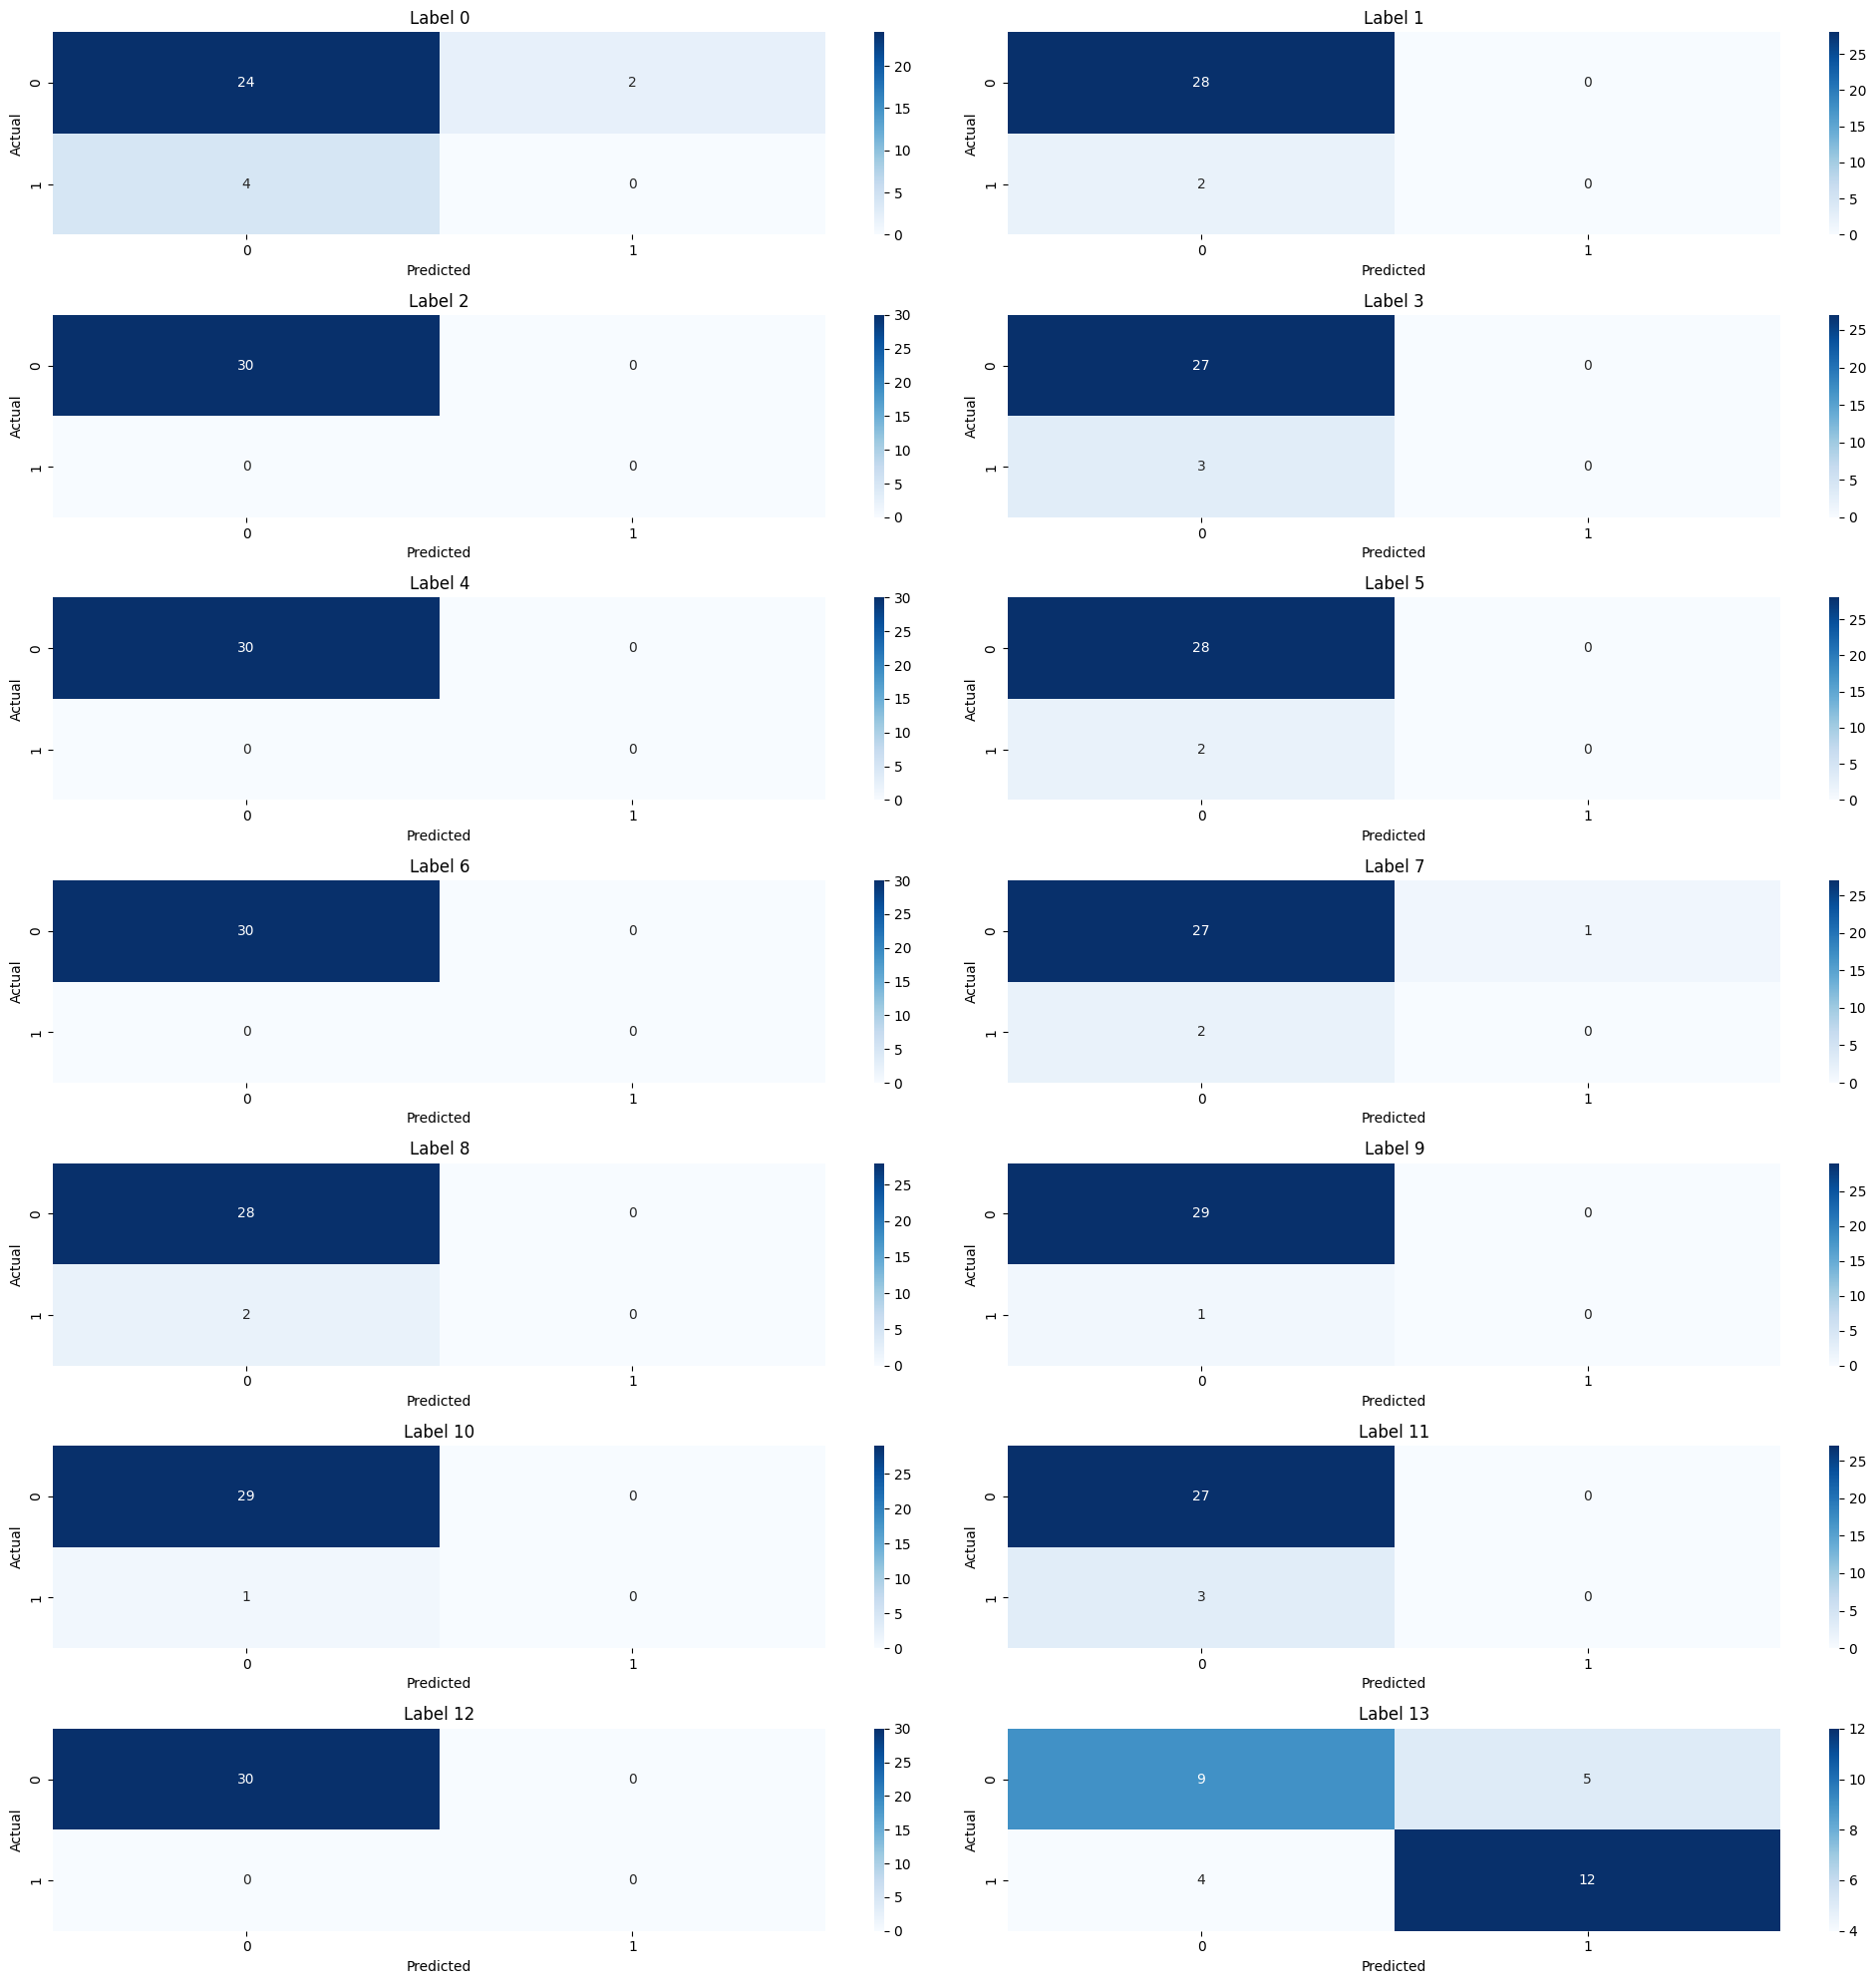

In [31]:
# Assuming `all_labels` and `binary_preds` are available from the evaluation function
# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# Plot each confusion matrix
num_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(7, 2, figsize=(20, 20))

axes = axes.flatten()

for i, ax in enumerate(axes):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [32]:
class MultimodalModel_1(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=14):
        super(MultimodalModel_1, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_proj = nn.Linear(text_hidden_size, 256)
        self.image_proj = nn.Linear(image_hidden_size, 256)
        self.gate = nn.Sequential(
            nn.Linear(512, 1), 
            nn.Sigmoid()
            )

        # Fusion Layer and Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
            # nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, image, label_vector):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_embeddings.last_hidden_state[:, 0, :]
        text_embeddings = self.text_proj(text_embeddings)

        # Image embeddings
        image_embeddings = self.image_encoder(image)
        image_embeddings = image_embeddings.last_hidden_state[:, 0, :]
        image_embeddings = self.image_proj(image_embeddings)

        # Concatenate
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        gate = self.gate(fused_embeddings)
        fused_embeddings = gate * text_embeddings + (1 - gate) * image_embeddings

        # Pass through classifier
        logits = self.classifier(fused_embeddings)

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            return loss, logits

        return logits

In [33]:
model = MultimodalModel_1()

# Training setup

training_args = TrainingArguments(
    output_dir='./results_multimodalmodel',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    # accuracy = (preds == torch.tensor(labels)).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='micro')
    auc_roc = roc_auc_score(labels, preds, average='micro')
    return {"accuracy": accuracy, "f1": f1, "auc-roc":auc_roc}

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [34]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc-roc
1,0.320000,0.281759,0.000000,0.000000,0.500000
2,0.292000,0.289808,0.033333,0.050000,0.510903
3,0.284000,0.283762,0.000000,0.000000,0.500000
4,0.272000,0.285658,0.100000,0.153846,0.539694
5,0.263100,0.294933,0.000000,0.000000,0.500000
6,0.250900,0.261339,0.233333,0.285714,0.588067
7,0.318100,0.254605,0.233333,0.311111,0.593289
8,0.271700,0.267285,0.100000,0.146341,0.539235
9,0.259200,0.251391,0.133333,0.195122,0.554054
10,0.230900,0.263043,0.200000,0.255319,0.575859


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [35]:
torch.save(model.state_dict(), "fusion2_chest_model.pth")
# Save the model
trainer.save_model()
# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.25460490584373474,
 'eval_accuracy': 0.23333333333333334,
 'eval_f1': 0.3111111111111111,
 'eval_auc-roc': 0.593289111565874,
 'eval_runtime': 1.3288,
 'eval_samples_per_second': 22.577,
 'eval_steps_per_second': 3.01,
 'epoch': 10.0}

In [36]:
model.load_state_dict(torch.load("fusion2_chest_model.pth"))

<All keys matched successfully>

In [37]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


In [38]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.296 (90% CI: 0.167 - 0.433)
f1: 0.386 (90% CI: 0.227 - 0.542)
auroc: 0.811 (90% CI: 0.734 - 0.892)
mcc: 0.450 (90% CI: 0.307 - 0.593)
brier: 0.064 (90% CI: 0.050 - 0.078)
sensitivity: 0.040 (90% CI: 0.026 - 0.054)
specificity: 0.995 (90% CI: 0.986 - 1.000)
balanced_accuracy: 0.518 (90% CI: 0.509 - 0.526)


In [39]:
class MultimodalModel_2(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=14):
        super(MultimodalModel_2, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        
        # Projection Layer
        self.text_proj = nn.Linear(text_hidden_size, image_hidden_size)

        # Cross-Attention Layer
        self.cross_attention = nn.MultiheadAttention(embed_dim=image_hidden_size, num_heads=4, batch_first=True)

        # Fusion Layer and Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(text_hidden_size + image_hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
            # nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, image, label_vector):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_tokens = text_embeddings.last_hidden_state
        text_tokens = self.text_proj(text_tokens)

        # Image embeddings
        image_embeddings = self.image_encoder(image)
        image_tokens = image_embeddings.last_hidden_state

        # Cross-Attention
        attn_output, _ = self.cross_attention(query=image_tokens, key=text_tokens, value=text_tokens)
        image_enhanced = attn_output[:, 0, :]  # Use CLS

        # Concatenate
        text_cls = text_embeddings.last_hidden_state[:, 0, :]
        fused_embeddings = torch.cat((text_cls, image_enhanced), dim=1)

        # Pass through classifier
        logits = self.classifier(fused_embeddings)

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            return loss, logits

        return logits

In [40]:
model = MultimodalModel_2()

# Training setup

training_args = TrainingArguments(
    output_dir='./results_multimodalmodel',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    # accuracy = (preds == torch.tensor(labels)).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='micro')
    auc_roc = roc_auc_score(labels, preds, average='micro')
    return {"accuracy": accuracy, "f1": f1, "auc-roc":auc_roc}

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [41]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc-roc
1,0.314300,0.278843,0.000000,0.000000,0.500000
2,0.265800,0.267246,0.200000,0.260870,0.577165
3,0.250900,0.252784,0.166667,0.266667,0.578470
4,0.280700,0.282336,0.266667,0.285714,0.593748
5,0.337800,0.361826,0.133333,0.218182,0.565415
6,0.525400,1.040969,0.200000,0.184615,0.552360
7,0.531300,0.315882,0.066667,0.085106,0.516583
8,0.437000,0.328765,0.000000,0.045455,0.505681
9,0.302600,0.348341,0.000000,0.000000,0.498695
10,0.310100,0.265792,0.000000,0.000000,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [42]:
torch.save(model.state_dict(), "fusion3_chest_model.pth")

In [43]:
trainer.save_model()

trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2823362946510315,
 'eval_accuracy': 0.26666666666666666,
 'eval_f1': 0.2857142857142857,
 'eval_auc-roc': 0.5937477947921812,
 'eval_runtime': 1.3809,
 'eval_samples_per_second': 21.725,
 'eval_steps_per_second': 2.897,
 'epoch': 10.0}

In [44]:
model.load_state_dict(torch.load("fusion3_chest_model.pth"))

<All keys matched successfully>

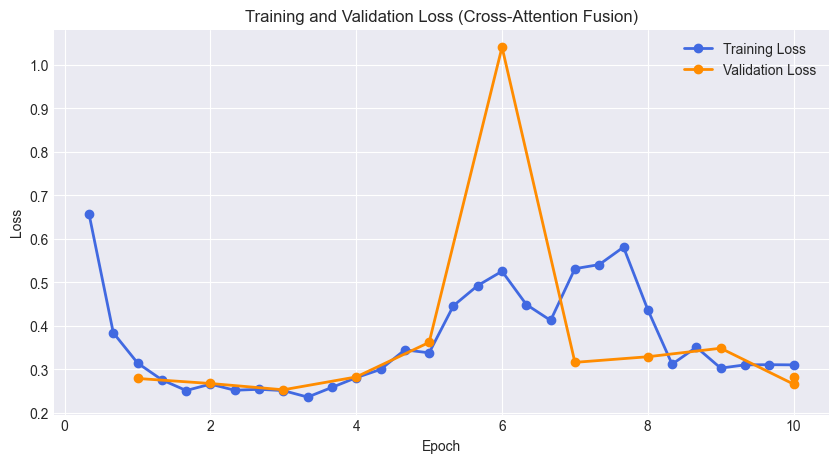

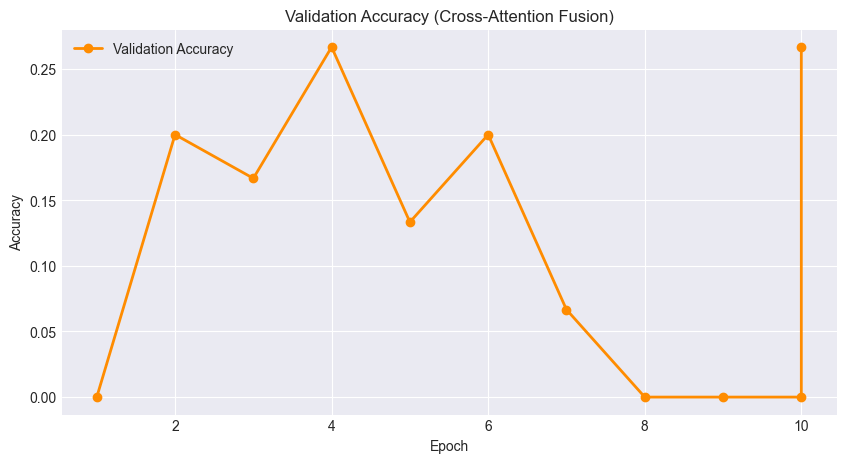

In [45]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Cross-Attention Fusion)")
plt.legend()
plt.grid(True)
plt.savefig("fusion3_chest_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (Cross-Attention Fusion)")
    plt.legend()
    plt.grid(True)
    plt.savefig("fusion3_chest_accuracy.png")
    plt.show()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


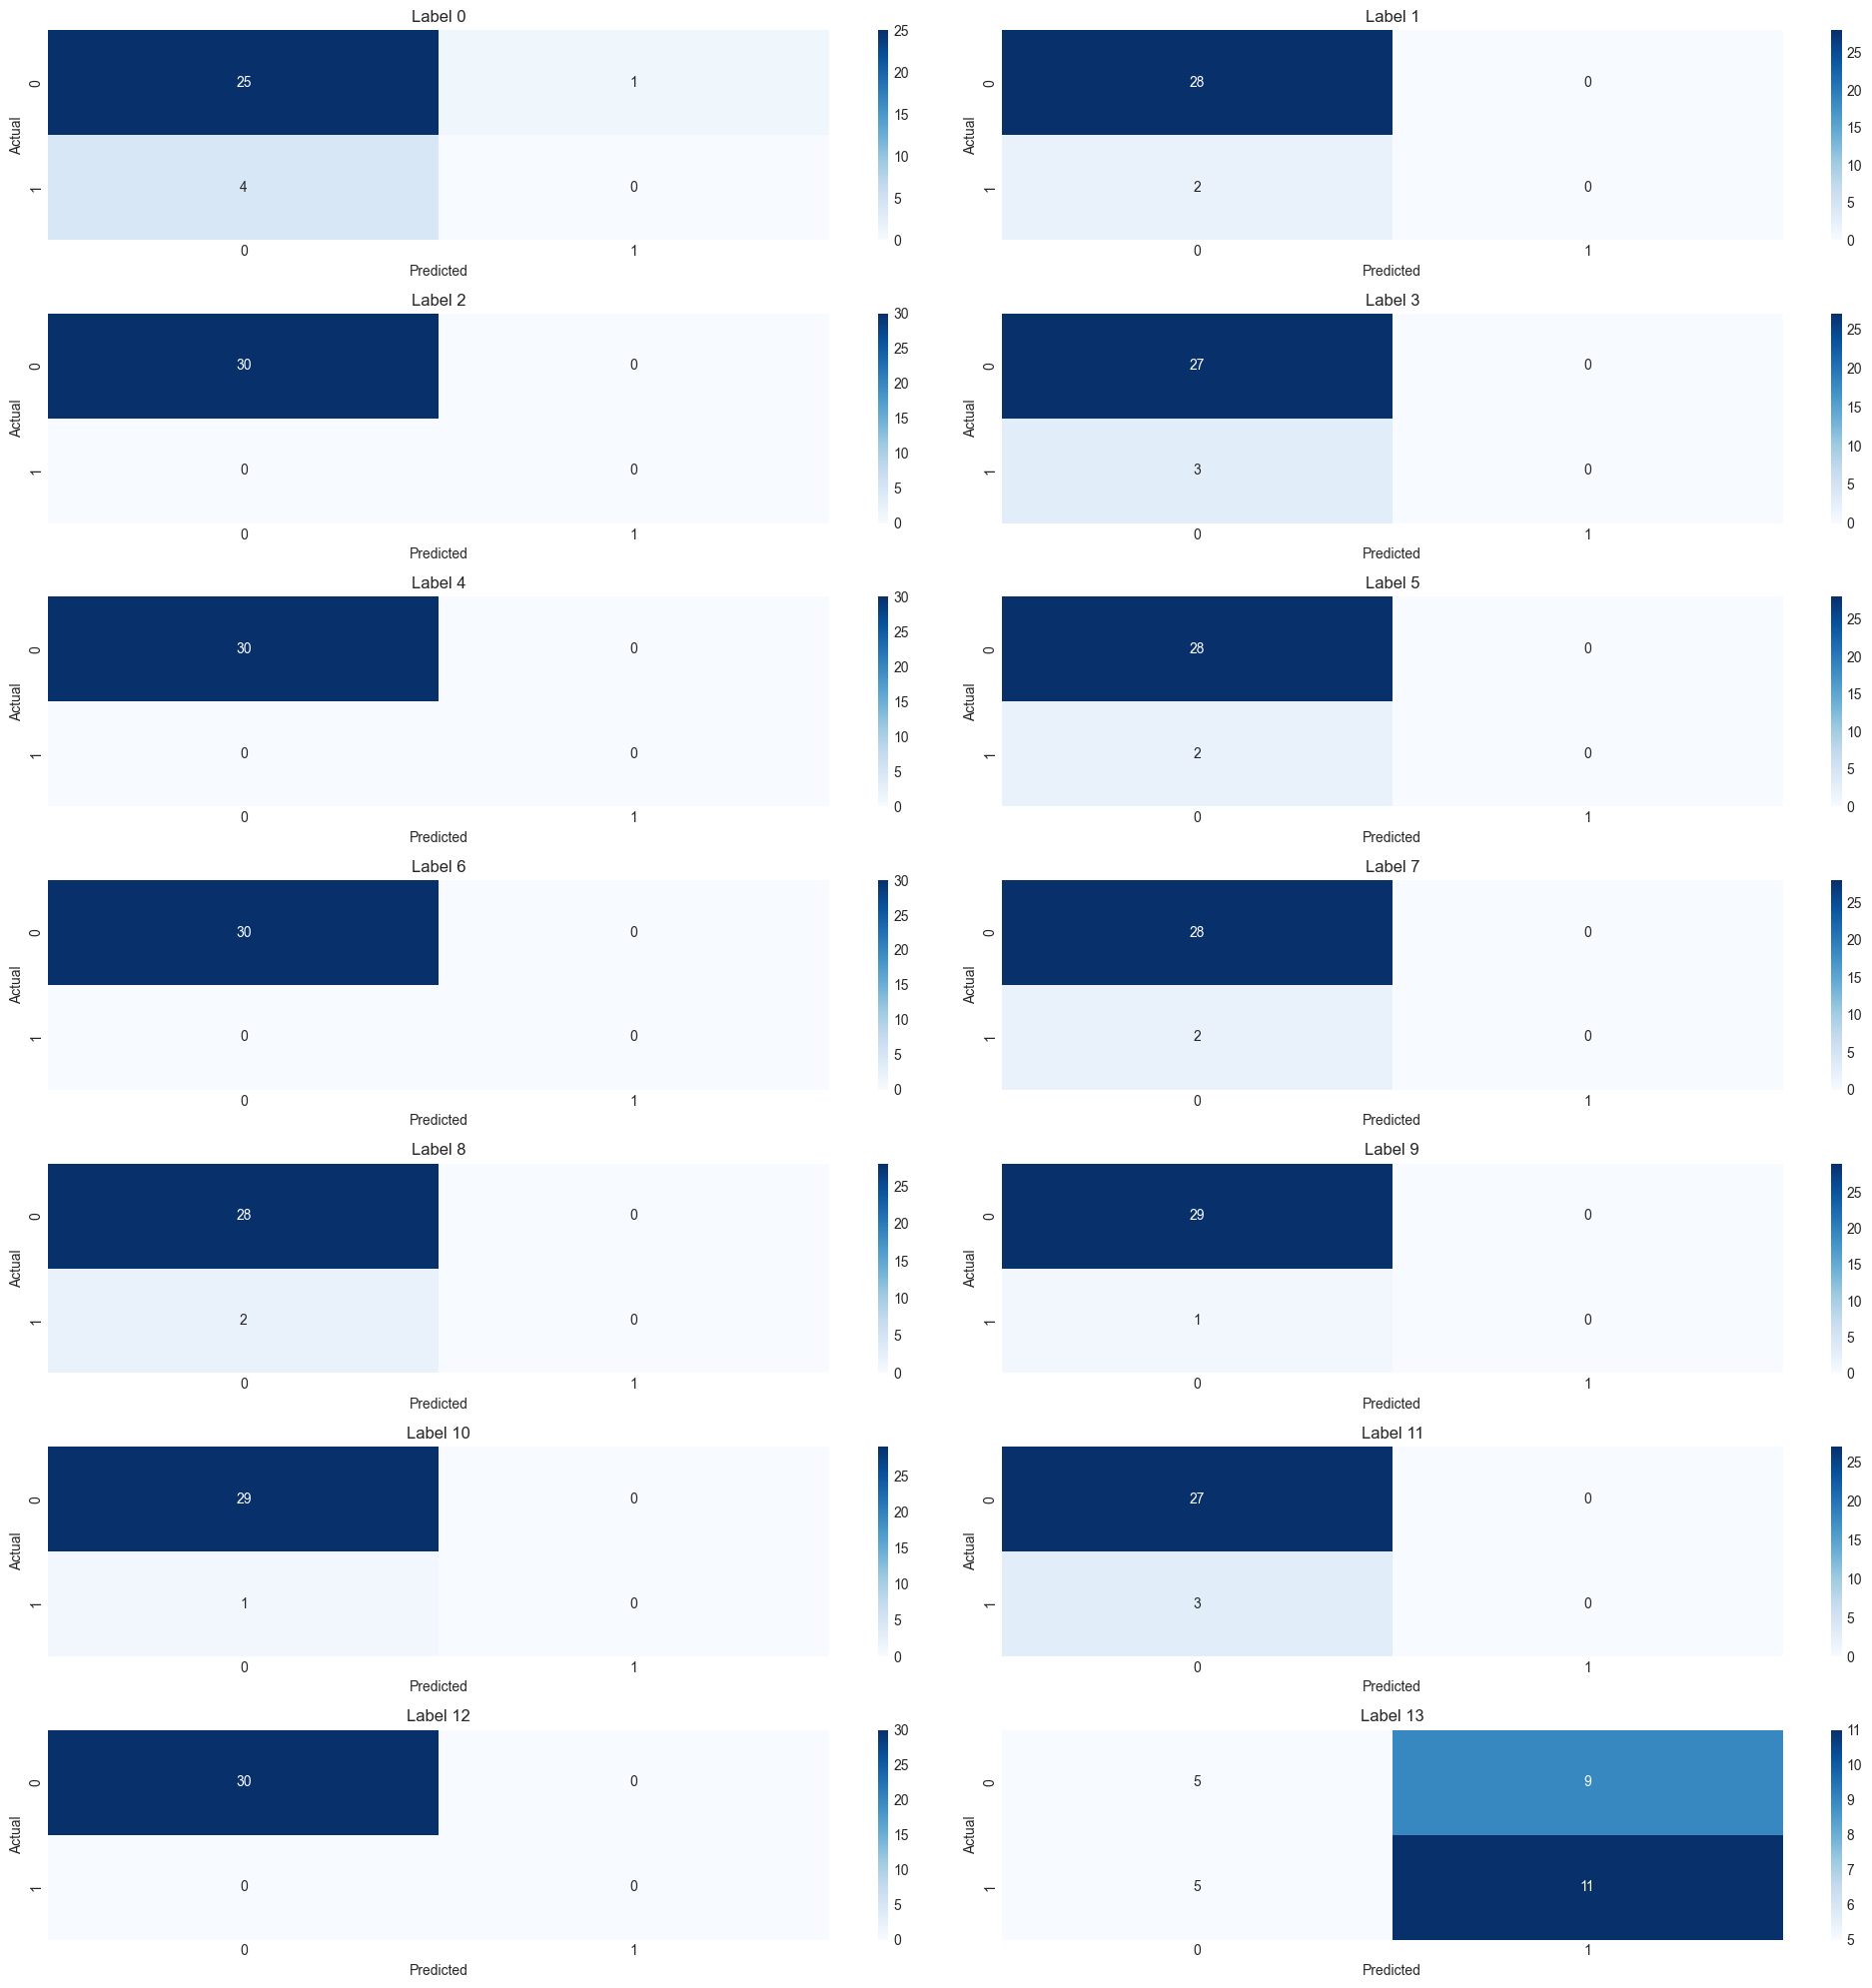

In [46]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

# Assuming `all_labels` and `binary_preds` are available from the evaluation function
# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# Plot each confusion matrix
num_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(7, 2, figsize=(20, 20))

axes = axes.flatten()

for i, ax in enumerate(axes):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [47]:
class_names = [
    "Atelectasis",
    "Consolidation",
    "Infiltration",
    "Pneumothorax",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Effusion",
    "Pneumonia",
    "Pleural_thickening",
    "Cardiomegaly",
    "Nodule Mass",
    "Hernia",
    "No Finding"
]

print("Class Names:", class_names)

Class Names: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule Mass', 'Hernia', 'No Finding']


In [48]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    brier_score_loss
)

def compute_additional_metrics(labels, preds):
    
    metrics = {
        "micro_f1": f1_score(labels, preds, average="micro"),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "roc_auc_micro": roc_auc_score(labels, preds, average="micro"),
        "matthews_corrcoef_micro": matthews_corrcoef(labels.flatten(), preds.flatten()),
    }

    # Compute brier score for each class
    brier_scores = []
    for i in range(labels.shape[1]):
        brier_scores.append(brier_score_loss(labels[:, i], preds[:, i]))
    
    metrics["brier_score_avg"] = sum(brier_scores) / len(brier_scores)

    sensitivities = []
    specificities = []
    balanced_accuracies = []

    for cm in confusion_matrices:
        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        balanced_accuracies.append(balanced_accuracy)

    metrics["sensitivity_avg"] = sum(sensitivities) / len(sensitivities)
    metrics["specificity_avg"] = sum(specificities) / len(specificities)
    metrics["balanced_accuracy_avg"] = sum(balanced_accuracies) / len(balanced_accuracies)

    return metrics


In [49]:
metrics = compute_additional_metrics(all_labels, binary_preds)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Print the metrics
print("Micro F1 Score:", metrics["micro_f1"])
print("ROC AUC Score (Micro):", metrics["roc_auc_micro"])
print("Matthews Correlation Coefficient (Micro):", metrics["matthews_corrcoef_micro"])
print("Brier Score (Average):", metrics["brier_score_avg"])
print("Sensitivity (Average):", metrics["sensitivity_avg"])
print("Specificity (Average):", metrics["specificity_avg"])
print("Balanced Accuracy (Average):", metrics["balanced_accuracy_avg"])


Micro F1 Score: 0.38596491228070173
ROC AUC Score (Micro): 0.6397569444444444
Matthews Correlation Coefficient (Micro): 0.359024561106316
Brier Score (Average): 0.08333333333333333
Sensitivity (Average): 0.049107142857142856
Specificity (Average): 0.9513343799058085
Balanced Accuracy (Average): 0.5002207613814756


In [51]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.363 (90% CI: 0.233 - 0.502)
f1: 0.382 (90% CI: 0.246 - 0.536)
auroc: 0.788 (90% CI: 0.703 - 0.870)
mcc: 0.354 (90% CI: 0.200 - 0.519)
brier: 0.066 (90% CI: 0.049 - 0.084)
sensitivity: 0.049 (90% CI: 0.034 - 0.062)
specificity: 0.951 (90% CI: 0.938 - 0.967)
balanced_accuracy: 0.500 (90% CI: 0.491 - 0.511)


In [52]:
sample_idx = 10  # Change this to view a different sample
print(f"Confidence scores for test sample {sample_idx}:")
print("Per-class confidence scores:", y_pred_probs[sample_idx])
print("Predicted labels:", y_pred[sample_idx])
print("Ground truth labels:", y_true[sample_idx])

Confidence scores for test sample 10:
Per-class confidence scores: [4.6250280e-02 8.1432826e-04 4.5844922e-06 1.3989506e-03 4.5470431e-02
 1.0575103e-02 7.0196074e-05 6.3250279e-03 4.2788323e-04 9.7518688e-04
 1.8296237e-01 3.5614353e-02 2.3792756e-03 8.1842303e-01]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Ground truth labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
